# GECCO2019 - Bi-objective Traveling Thief Problem 

This worksheet contains the evaluation for the competition at **GECCO2019**. 
After having received all submissions, the evaluation will be done as follows:

After having received all submissions, the evaluation will be done as follows:

For each of the nine test problems

a) We will merge the solution sets of all submissions and extract the non-dominated set.

b) The minimum in time and the maximum in profit will be used to determine the reference point.

c) With respect to this reference point the quality of each submission will be measured using the hypervolume indicator.

d) We will sort the submissions according to the achieved hypervolume in descending order and give points as follows: 1st place -> 3 points, 2nd place -> 2 points, 3rd place -> 1 point.


By adding up the points for each submission we will create the overall ranking. Please note, that depending on the number of submissions the evaluation might need to be reconsidered.

The validation has already been done using the Java code. Which means that each submission has the correct number of solutions (less than the maximum specfied at the competition homepage).


## Imports necessary for the evaluation

## Participants and Problems

In [1]:
from non_dominated_sorting import fast_non_dominated_sort
import os.path
import numpy as np
import matplotlib.pyplot as plt
from hv import Hypervolume
from normalization import normalize
import pandas as pd
# the result folder as a path
folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "evaluations/results")

# all submissions received
participant_names = [   
                    "NDS-BRKGA",
                      "PN-PHN",
                      "AM-PHN",
                    "PN-DRLMOA",
                    "AM-DRLMOA",
                      "PN-MBPS",
                      "AM-MBPS"
               ]

participants = [   
                    "nds-brkga_bi",
                    "PN-DRLMOA",
                    "AM-DRLMOA",
                      "PN-PHN",
                      "AM-PHN",
#                     "mpn-r1nes-lin",
#                     "mpn-r1nes",
                    
#                     "mpn-phn-eil",
#                     "mpn-eil",
#                     "att-drlmoa-eil",
#                     "att-r1nes-eil",
#                     "att-phn-eil"
                      "PN-MBPS",
                      "AM-MBPS"
               ]

participant_name_dict = {
    "nds-brkga_bi":"NDS-BRKGA",
    "PN-DRLMOA":"PN-DRLMOA",
    "AM-DRLMOA":"AM-DRLMOA",
    "PN-PHN":"PN-PHN",
    "AM-PHN":"AM-PHN",
    "PN-MBPS":"PN-MBPS",
    "AM-MBPS":"AM-MBPS",
    "mpn-r1nes-lin":"PN-MBPS",
    "mpn-phn-eil":"PN-PHN",
    "mpn-eil":"PN-DRLMOA",
    "att-drlmoa-eil":"AM-DRLMOA",
    "att-r1nes-eil":"AM-MBPS",
    "att-phn-eil":"AM-PHN"
    
}

config_name_list = [
    "ch150_n1490_bounded-strongly-corr",
    "ch150_n1490_uncorr-similar-weights",
    "ch150_n1490_uncorr",
    "ch150_n149_bounded-strongly-corr",
    "ch150_n149_uncorr-similar-weights",
    "ch150_n149_uncorr",
    "ch150_n447_bounded-strongly-corr",
    "ch150_n447_uncorr-similar-weights",
    "ch150_n447_uncorr",
    "ch150_n745_bounded-strongly-corr",
    "ch150_n745_uncorr-similar-weights",
    "ch150_n745_uncorr",
#     "eil76_n225_bounded-strongly-corr",
#     "eil76_n225_uncorr-similar-weights",
#     "eil76_n225_uncorr",
#     "eil76_n375_bounded-strongly-corr",
#     "eil76_n375_uncorr-similar-weights",
#     "eil76_n375_uncorr",
#     "eil76_n750_bounded-strongly-corr",
#     "eil76_n750_uncorr-similar-weights",
#     "eil76_n750_uncorr",
#     "eil76_n75_bounded-strongly-corr",
#     "eil76_n75_uncorr-similar-weights",
#     "eil76_n75_uncorr",
#       "lin105_n1040_uncorr",
#     "lin105_n1040_bounded-strongly-corr",
#     "lin105_n1040_uncorr-similar-weights",
#     "lin105_n104_bounded-strongly-corr",
#     "lin105_n104_uncorr-similar-weights",
#     "lin105_n104_uncorr",
#     "lin105_n312_bounded-strongly-corr",
#     "lin105_n312_uncorr-similar-weights",
#     "lin105_n312_uncorr",
#     "lin105_n520_bounded-strongly-corr",
#     "lin105_n520_uncorr-similar-weights",
#     "lin105_n520_uncorr"
]
num_instance_per_problem = 10
problems = []
for config_name in config_name_list:
    for i in range(1,num_instance_per_problem+1):
        idx = str(i)
        if i<10:
            idx = "0"+idx
        problems += [config_name+"_"+idx]

## Load data

Load all data from the submission directory and convert it to a minimization problem.
The data dictionary contains all submissions of a participant. The set of non-dominated points
is converted to a minimization problem by multiplying the profit times -1.

In [2]:
data = {}
for problem in problems:
    _entry = {}
    for participant in participants:
        
        # check for the corresponding file
        fname = "%s_%s.f" % (participant, problem)   
        path_to_file = os.path.join(folder,participant, fname)
        
        # in case the wrong delimiter was used
        if not os.path.isfile(path_to_file):
            fname = "%s_%s.f" % (participant, problem.replace("_", "-"))
            path_to_file = os.path.join(folder,participant, fname)
         
        # load the values in the objective space - first column is time, second profit
        _F = np.loadtxt(path_to_file)
        
        # modify it to a min-min problem by multiplying the profit by -1
        _entry[participant] = _F * [1, -1]
        
    data[problem] = _entry

## Find the reference non-dominated set for each test instance

For each problem we merge the submissions to a new population and filter out the non-dominated solutions. Then, we take the minimum and the maximum of this set as the ideal and nadir point the normalize the results.

In [3]:

ideal_point = {}
nadir_point = {}
ndf = {}

for problem in problems:
    
    # the merged non-dominated solutions for the specific problem
    M = []
    for participant in participants:    
        _F = data[problem][participant]
        M.append(_F)
        
    M = np.vstack(M)    
    I = fast_non_dominated_sort(M)[0]
    M = M[I, :]
    
    ideal_point[problem] = np.min(M, axis=0)
    nadir_point[problem] = np.max(M, axis=0)
    ndf[problem] = M
    
    

In the following for each problem the non-dominated set of solutions is first normalized using the boundaries and hypervolume is calculated.

In [4]:
results = []

for problem in problems:
    
    z = ideal_point[problem]
    z_nad = nadir_point[problem]
 
    for participant in participants:    
        _F = data[problem][participant]
        _N = normalize(_F, z, z_nad)
        _hv = Hypervolume(np.array([1,1])).calc(_N)
        participant_label = participant_name_dict[participant]
        results.append({'problem' : problem, 'participant' : participant_label, 'hv' : _hv})
        
df = pd.DataFrame(results, columns=["problem", "participant", "hv"])
print(df)

                                  problem participant        hv
0    ch150_n1490_bounded-strongly-corr_01   NDS-BRKGA  0.928229
1    ch150_n1490_bounded-strongly-corr_01   PN-DRLMOA  0.867475
2    ch150_n1490_bounded-strongly-corr_01   AM-DRLMOA  0.852850
3    ch150_n1490_bounded-strongly-corr_01      PN-PHN  0.810649
4    ch150_n1490_bounded-strongly-corr_01      AM-PHN  0.810009
..                                    ...         ...       ...
835                  ch150_n745_uncorr_10   AM-DRLMOA  0.873652
836                  ch150_n745_uncorr_10      PN-PHN  0.744424
837                  ch150_n745_uncorr_10      AM-PHN  0.823386
838                  ch150_n745_uncorr_10     PN-MBPS  0.756048
839                  ch150_n745_uncorr_10     AM-MBPS  0.791983

[840 rows x 3 columns]


Get Average ranking over All instances

In [5]:
df_temp = df.copy()
df_temp["rank_per_prob"] = df_temp.groupby("problem")["hv"].rank(ascending=False)
df_par_rank = df_temp[["participant","rank_per_prob"]]
avg_par_rank = df_par_rank.groupby("participant")["rank_per_prob"].mean()
print(avg_par_rank)

participant
AM-DRLMOA    2.641667
AM-MBPS      5.125000
AM-PHN       4.225000
NDS-BRKGA    2.525000
PN-DRLMOA    2.500000
PN-MBPS      5.908333
PN-PHN       5.075000
Name: rank_per_prob, dtype: float64


Get Wilcoxon Rank Sum Test Verdict to Winner

In [6]:
results_analysis = []
for participant in participant_names:
    df_p = df[df["participant"]==participant]
    for config_name in config_name_list:
        cf = config_name + "_"
        df_p_c = df_p[df_p["problem"].str.contains(cf)]
#         participant_label = participant_name_dict[participant]
        average, std = df_p_c["hv"].mean(), df_p_c["hv"].std()
        results_analysis += [{"participant":participant, "config":config_name, "average":average, "std":std}]
df_analysis = pd.DataFrame(results_analysis, columns=["participant","config","average","std"])
df_analysis.to_csv("ch150_hv_analysis.csv")

In [7]:
from scipy.stats import ranksums
#PERFORM Wilcoxon Rank Sum Test
BETTER="+"
WORSE="-"
EQUAL="="
max_pval = 0.05
def get_verdict(df1, df2):
    verdict=EQUAL
    #CHECK if BETTER
    rs_greater = ranksums(df1, df2, alternative="greater")
    rs_less = ranksums(df1, df2, alternative="less")
    if rs_greater.pvalue<max_pval:
        verdict=BETTER
    elif rs_less.pvalue<max_pval:
        verdict=WORSE
    return verdict
    
winner = "NDS-BRKGA"
results_ranksum = []
df_w = df[df["participant"]==winner]
for participant in participant_names:
    df_p = df[df["participant"]==participant]
    for config_name in config_name_list:
        df_p_c = df_p[df_p["problem"].str.contains(config_name+"_")]
        df_w_c = df_w[df_w["problem"].str.contains(config_name+"_")]
        print(participant, config_name)
        print(df_p_c)
        print(df_w_c)
        verdict = get_verdict(df_p_c["hv"], df_w_c["hv"])
        results_ranksum += [{"participant":participant, "config":config_name, "verdict":verdict}]
df_ranksum = pd.DataFrame(results_ranksum, columns=["participant","config","verdict"])
print(df_ranksum)
df_ranksum.to_csv("ch150_ranksum.csv")
#             print(winner, participant, config_name, )

NDS-BRKGA ch150_n1490_bounded-strongly-corr
                                 problem participant        hv
0   ch150_n1490_bounded-strongly-corr_01   NDS-BRKGA  0.928229
7   ch150_n1490_bounded-strongly-corr_02   NDS-BRKGA  0.924867
14  ch150_n1490_bounded-strongly-corr_03   NDS-BRKGA  0.911031
21  ch150_n1490_bounded-strongly-corr_04   NDS-BRKGA  0.902127
28  ch150_n1490_bounded-strongly-corr_05   NDS-BRKGA  0.886532
35  ch150_n1490_bounded-strongly-corr_06   NDS-BRKGA  0.876738
42  ch150_n1490_bounded-strongly-corr_07   NDS-BRKGA  0.861120
49  ch150_n1490_bounded-strongly-corr_08   NDS-BRKGA  0.843074
56  ch150_n1490_bounded-strongly-corr_09   NDS-BRKGA  0.822089
63  ch150_n1490_bounded-strongly-corr_10   NDS-BRKGA  0.808999
                                 problem participant        hv
0   ch150_n1490_bounded-strongly-corr_01   NDS-BRKGA  0.928229
7   ch150_n1490_bounded-strongly-corr_02   NDS-BRKGA  0.924867
14  ch150_n1490_bounded-strongly-corr_03   NDS-BRKGA  0.911031
21  ch150_n

PN-MBPS ch150_n149_uncorr
                  problem participant        hv
355  ch150_n149_uncorr_01     PN-MBPS  0.555864
362  ch150_n149_uncorr_02     PN-MBPS  0.540364
369  ch150_n149_uncorr_03     PN-MBPS  0.575697
376  ch150_n149_uncorr_04     PN-MBPS  0.551362
383  ch150_n149_uncorr_05     PN-MBPS  0.554367
390  ch150_n149_uncorr_06     PN-MBPS  0.538333
397  ch150_n149_uncorr_07     PN-MBPS  0.565685
404  ch150_n149_uncorr_08     PN-MBPS  0.552421
411  ch150_n149_uncorr_09     PN-MBPS  0.548194
418  ch150_n149_uncorr_10     PN-MBPS  0.560457
                  problem participant        hv
350  ch150_n149_uncorr_01   NDS-BRKGA  0.899105
357  ch150_n149_uncorr_02   NDS-BRKGA  0.881931
364  ch150_n149_uncorr_03   NDS-BRKGA  0.891376
371  ch150_n149_uncorr_04   NDS-BRKGA  0.860451
378  ch150_n149_uncorr_05   NDS-BRKGA  0.855950
385  ch150_n149_uncorr_06   NDS-BRKGA  0.845830
392  ch150_n149_uncorr_07   NDS-BRKGA  0.858413
399  ch150_n149_uncorr_08   NDS-BRKGA  0.861463
406  ch150_n14

Get average over config groups

In [13]:
df_temp = df.copy()

get average hv over number of items

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

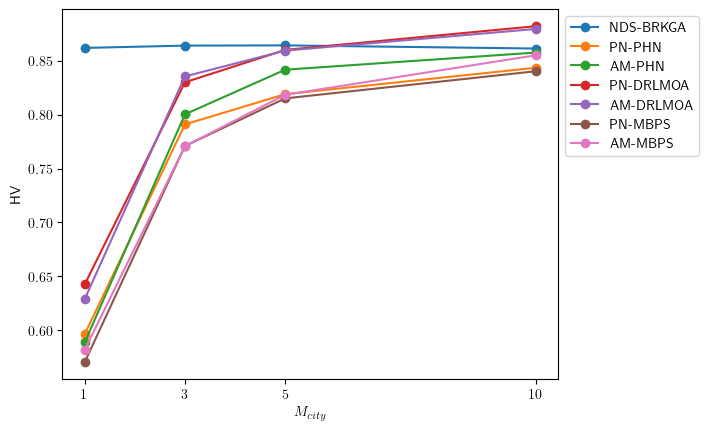

In [9]:
df_temp = df.copy()
# nlist = [75,225,375,750]
# nlist = [104,412,520,1040]
nlist = [149, 447, 745, 1490]
len_participant = 7
new_df = None
for n in nlist:
    n_str = "n"+str(n)+"_"
    ncol = [n for _ in range(len_participant)]
    df_n = df_temp[df_temp["problem"].str.contains(n_str)]
    df_average = df_n.groupby("participant")["hv"].mean().reset_index(name="hv")
    df_average["n"] = ncol
    if new_df is None:
        new_df = df_average
    else:
        new_df = pd.concat([new_df, df_average])
for participant in participant_names:
    ndf_p = new_df[new_df["participant"]==participant]
#     participant_name = participant_name_dict[participant]
    plt.plot(np.asanyarray([1,3,5,10]), ndf_p["hv"], marker="o", label=participant)
plt.xlabel(r'$M_{city}$')
plt.ylabel("HV")
plt.xticks(np.asanyarray([1,3,5,10]))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("ch150/ch150_m_plot.jpg", dpi=200, bbox_inches='tight')
plt.show()

Average over all knapsack capacity

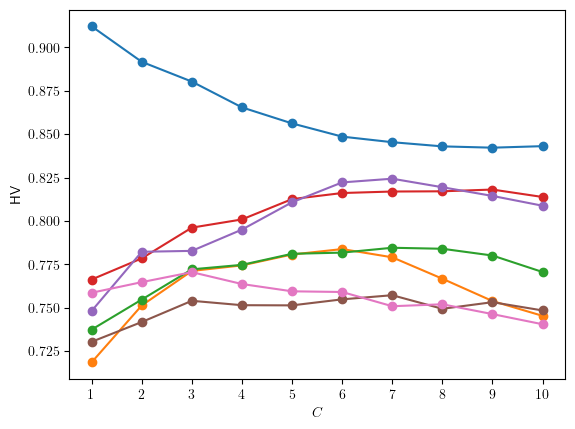

In [10]:
df_temp = df.copy()

clist = []
for i in range(1,11):
    c = str(i)
    if i<10:
        c = "0"+c
    c = "_"+c
    clist += [c]
    
len_participant = 7
new_df = None
for i in range(10):
    c = clist[i]
    ccol = [i+1 for _ in range(len_participant)]
    df_c = df_temp[df_temp["problem"].str.contains(c)]
    df_average = df_c.groupby("participant")["hv"].mean().reset_index(name="hv")
    df_average["c"] = ccol
    if new_df is None:
        new_df = df_average
    else:
        new_df = pd.concat([new_df, df_average])
from scipy.stats import pearsonr
for participant in participant_names:
    ndf_p = new_df[new_df["participant"]==participant]
#     print(participant, ndf_p)
#     participant_name = participant_name_dict[participant]
#     print(participant)
#     print(pearsonr(ndf_p["c"], ndf_p["hv"]))
    plt.plot(ndf_p["c"], ndf_p["hv"], marker="o", label=participant)
plt.xlabel(r'$C$')
plt.ylabel("HV")
plt.xticks(np.arange(10)+1)
# plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("ch150/ch150_c_plot.jpg", dpi=200, bbox_inches='tight')
plt.show()

average over different correlation

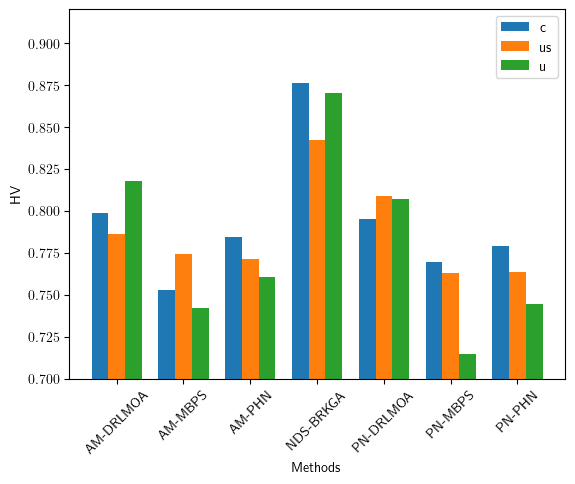

In [14]:
cor_list = ["bounded-strongly-corr_", "uncorr-similar-weights_", "_uncorr_"]
cor_labels = ["c", "us", "u"]
df_temp = df.copy()
len_participant = 7
new_df = None
for i in range(len(cor_list)):
    cor = cor_list[i]
    coridx_col = [i for _ in range(len_participant)]
    df_n = df_temp[df_temp["problem"].str.contains(cor)]
    df_average = df_n.groupby("participant")["hv"].mean().reset_index(name="hv")
    df_average["cor"] = coridx_col
    if new_df is None:
        new_df = df_average
    else:
        new_df = pd.concat([new_df, df_average])

width = 1
x = np.arange(len(participants))*4
for j, cor_label in enumerate(cor_labels):
    ndf_cor = new_df[new_df["cor"]==j]
    participant_labels_df = ndf_cor["participant"]
    plt.bar(x+j*width, ndf_cor["hv"], width=width,  label=cor_label)
    
plt.xlabel("Methods")
plt.ylabel("HV")
plt.ylim(0.7)
plt.xticks(x+1*width, participant_labels_df, rotation=45)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("ch150/ch150_cor_plot.jpg", dpi=200, bbox_inches='tight', )
plt.show()

In [29]:
print(df.to_csv("all_hv.csv"))

for problem in problems:

    print("=" * 60)
    print(problem)
    print("=" * 60)
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True, inplace=True)
    print(_df)

None
eil76_n225_bounded-strongly-corr_01
                               problem participant        hv
0  eil76_n225_bounded-strongly-corr_01   NDS-BRKGA  0.921593
1  eil76_n225_bounded-strongly-corr_01   PN-DRLMOA  0.845308
2  eil76_n225_bounded-strongly-corr_01     AM-MBPS  0.841210
3  eil76_n225_bounded-strongly-corr_01     PN-MBPS  0.839615
4  eil76_n225_bounded-strongly-corr_01      PN-PHN  0.816965
5  eil76_n225_bounded-strongly-corr_01   AM-DRLMOA  0.809397
6  eil76_n225_bounded-strongly-corr_01      AM-PHN  0.806422
eil76_n225_bounded-strongly-corr_02
                               problem participant        hv
0  eil76_n225_bounded-strongly-corr_02   NDS-BRKGA  0.927005
1  eil76_n225_bounded-strongly-corr_02   PN-DRLMOA  0.875301
2  eil76_n225_bounded-strongly-corr_02   AM-DRLMOA  0.869668
3  eil76_n225_bounded-strongly-corr_02     AM-MBPS  0.863130
4  eil76_n225_bounded-strongly-corr_02     PN-MBPS  0.858276
5  eil76_n225_bounded-strongly-corr_02      PN-PHN  0.852274
6  eil76

The data frame contains all results. Now, we need to rank the submission for each test instance:

In [30]:
# the final ranking. And add zero points initially (sum is later taken anyway...)
ranking = []
for participant in participants:
    ranking.append({'participant': participant, 'points' : 0})


# one more time loop through problem wise
for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    
    # sort descending by hv
    _df.sort_values("hv", ascending=False, inplace=True)
    
    # 3 points for the 1st place
    first = _df.iloc[0]["participant"]
    ranking.append({'participant': first, 'points' : 3})
    
    # 2 points for the 2nd place
    second = _df.iloc[1]["participant"]
    ranking.append({'participant': second, 'points' : 2})
    
    # 1 point for the 3rd place
    third = _df.iloc[2]["participant"]
    ranking.append({'participant': third, 'points' : 1})

    
ranking = pd.DataFrame(ranking, columns=["participant", "points"])

# Leaderboard

Finally, we sum up the hypervolume for each problem and evaluate the winner!

In [31]:
ranking.groupby('participant').sum().sort_values("points", ascending=False)

,points
participant,
NDS-BRKGA,172
PN-DRLMOA,138
AM-DRLMOA,122
AM-PHN,108
AM-MBPS,87
PN-MBPS,71
PN-PHN,22
nds-brkga_bi,0


## Leaderboard as HTML

In [13]:


standalone = True
if standalone:
    print("<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>")
    print("<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>")
    print("<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>")

print("<div class='row'><div class='w-50'>")
print("<table class='table'>")
print("<tr><th>Problem</th><th>Team</th><th>Hypervolume</th><th>Estimated Ideal Point</th><th>Estimated Nadir Point</th></tr>")

for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True)
    
    first = True
    for i, e in _df.iterrows():
        
        problem, team, hv = e.values
        
        if first:
            
            s_row_span = "<th rowspan='%s'>%s</th>"
            
            s_problem = s_row_span % (len(_df), problem)
            s_ideal = s_row_span % (len(_df), "(%s, %s)" % (round(ideal_point[problem][0]), round(ideal_point[problem][1])))
            s_nadir = s_row_span % (len(_df), "(%s, %s)" % (round(nadir_point[problem][0]), round(nadir_point[problem][1])))
            
            print("<tr>%s <th>%s</th> <th>%s</th> %s %s  </tr>" 
                  % (s_problem, team, round(hv,4), s_ideal, s_nadir))
        else:
            print("<tr><th>%s</th><th>%s</th></tr>" % (team, round(hv,4)))
        
            
        first = False
        
    print()
    
    
print("<table>")
print("</div></div>")

<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>
<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>
<div class='row'><div class='w-50'>
<table class='table'>
<tr><th>Problem</th><th>Team</th><th>Hypervolume</th><th>Estimated Ideal Point</th><th>Estimated Nadir Point</th></tr>
<tr><th rowspan='7'>eil76_n225_bounded-strongly-corr_01</th> <th>nds-brkga_bi</th> <th>0.9114</th> <th rowspan='7'>(585, -33269)</th> <th rowspan='7'>(1205, 0)</th>  </tr>
<tr><th>att-drlmoa-eil</th><th>0.8583</th></tr>
<tr><th>mpn-eil<

<tr><th rowspan='7'>eil76_n75_uncorr-similar-weights_10</th> <th>nds-brkga_bi</th> <th>0.9736</th> <th rowspan='7'>(585, -38254)</th> <th rowspan='7'>(5154, 0)</th>  </tr>
<tr><th>mpn-eil</th><th>0.9409</th></tr>
<tr><th>mpn-r1nes</th><th>0.933</th></tr>
<tr><th>att-drlmoa-eil</th><th>0.9317</th></tr>
<tr><th>att-r1nes-eil</th><th>0.9135</th></tr>
<tr><th>mpn-phn-eil</th><th>0.8942</th></tr>
<tr><th>att-phn-eil</th><th>0.866</th></tr>

<tr><th rowspan='7'>eil76_n75_uncorr_01</th> <th>nds-brkga_bi</th> <th>0.8288</th> <th rowspan='7'>(585, -12617)</th> <th rowspan='7'>(1132, 0)</th>  </tr>
<tr><th>mpn-eil</th><th>0.6018</th></tr>
<tr><th>mpn-r1nes</th><th>0.592</th></tr>
<tr><th>att-r1nes-eil</th><th>0.5787</th></tr>
<tr><th>att-drlmoa-eil</th><th>0.517</th></tr>
<tr><th>mpn-phn-eil</th><th>0.4901</th></tr>
<tr><th>att-phn-eil</th><th>0.3903</th></tr>

<tr><th rowspan='7'>eil76_n75_uncorr_02</th> <th>nds-brkga_bi</th> <th>0.8781</th> <th rowspan='7'>(585, -18448)</th> <th rowspan='7'>(1

In [14]:
_ranking = ranking.groupby('participant').sum().sort_values("points", ascending=False)

standalone = True
if standalone:
    print("<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>")
    print("<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>")
    print("<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>")


print("<div class='row'><div class='w-50'>")
print("<table class='table'>")
print("<tr><th>Rank</th><th>Team</th><th>Points</th></tr>")


counter = 0
for i, e in _ranking.iterrows():
    print("<tr><th>%s</th><th>%s</th><th>%s</th></tr>" % (counter+1, i, e[0]))
    counter += 1

    
print("<table>")
print("</div></div>")


<script src='https://code.jquery.com/jquery-3.2.1.slim.min.js' integrity='sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN' crossorigin='anonymous'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.12.9/umd/popper.min.js' integrity='sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q' crossorigin='anonymous'></script>
<script src='https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js' integrity='sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl' crossorigin='anonymous'></script>
<div class='row'><div class='w-50'>
<table class='table'>
<tr><th>Rank</th><th>Team</th><th>Points</th></tr>
<tr><th>1</th><th>mpn-eil</th><th>214</th></tr>
<tr><th>2</th><th>att-drlmoa-eil</th><th>190</th></tr>
<tr><th>3</th><th>nds-brkga_bi</th><th>161</th></tr>
<tr><th>4</th><th>mpn-r1nes</th><th>119</th></tr>
<tr><th>5</th><th>att-r1nes-eil</th><th>23</th></tr>
<tr><th>6</th><th>mpn-phn-eil</th><th>13</th>